# EDA

In [4]:
!pip install -U datasets > /dev/null

In [3]:
from datasets import load_dataset
dataset = load_dataset('HC-85/hey-banco-datathon-2024-tweets')['train']

In [4]:
import pandas as pd
data = dataset.to_pandas()

### Datos faltantes

In [5]:
data.isna().sum()/len(data)

date     0.000000
time     0.477833
tweet    0.000000
dtype: float64

### Rango de fechas

In [6]:
data['date'] = pd.to_datetime(data['date'])
max_date = data['date'].max()
min_date = data['date'].min()
print(f'{min_date.month_name()} {min_date.day}, {min_date.year} - {max_date.month_name()} {max_date.day}, {max_date.year}')

January 1, 2023 - April 26, 2024


In [7]:
data['day_index'] = pd.to_datetime(data['date']).astype(int)//(10**9 * 60 * 60 * 24)
data['day_index'] = data['day_index'] - min(data['day_index'])

In [8]:
tweets_per_day = data.groupby('day_index')['tweet'].count()

In [9]:
tweets_per_week = tweets_per_day.rolling(window = 7, axis = 0).sum()

/tmp/ipykernel_35/1760807083.py:1: FutureWarning: The 'axis' keyword in Series.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  tweets_per_week = tweets_per_day.rolling(window = 7, axis = 0).sum()


In [10]:
rolling_sum_tweets = tweets_per_day.rolling(window = 14, axis = 0).sum()

/tmp/ipykernel_35/3106866356.py:1: FutureWarning: The 'axis' keyword in Series.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  rolling_sum_tweets = tweets_per_day.rolling(window = 14, axis = 0).sum()


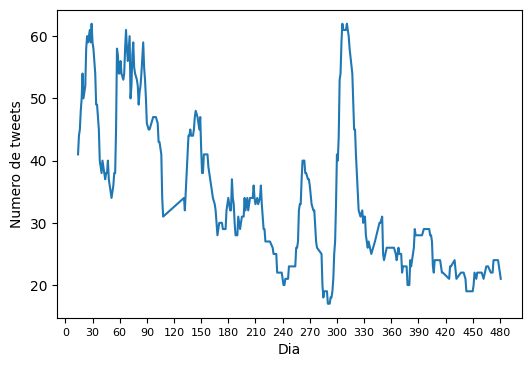

In [16]:
from matplotlib import pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(rolling_sum_tweets)
ax.set_xlabel('Dia')
ax.set_ylabel('Numero de tweets')
ax.set_xticks(np.arange(0, max(data['day_index'])+1, 30))
ax.set_xticklabels(np.arange(0, max(data['day_index'])+1, 30), fontsize=8)
plt.show()

# Análisis de sentimiento

## ES $\rightarrow$ EN

In [17]:
!pip install -U accelerate datasets > /dev/null

In [18]:
from datasets import load_dataset
dataset = load_dataset('HC-85/hey-banco-datathon-2024-tweets')['train']

In [19]:
from transformers import MarianMTModel, MarianTokenizer
model_chkpt = "Helsinki-NLP/opus-mt-es-en"

def tokenize(batch, column, tokenizer):
  return tokenizer(batch[column], padding = True, truncation=True, max_length=512, return_tensors='pt')

def send_to_cuda(input_ids, attention_mask):
  return {'input_ids': input_ids.to('cuda'), 'attention_mask': attention_mask.to('cuda')}

def translate(batch, model, tokenizer):
  outputs = model.generate(**send_to_cuda(**batch))
  translations = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
  return {'translation': [translation for translation in translations]}

In [20]:
tokenizer = MarianTokenizer.from_pretrained(model_chkpt)
input_cols = dataset.map(lambda x: tokenize(x, 'tweet', tokenizer), batched=True)
input_cols = input_cols.select_columns(['input_ids', 'attention_mask'])
input_cols = input_cols.with_format('torch', columns=['input_ids', 'attention_mask'])

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Map:   0%|          | 0/812 [00:00<?, ? examples/s]

In [21]:
model = MarianMTModel.from_pretrained(model_chkpt, device_map = 'cuda')
input_cols = input_cols.map(lambda x: translate(x, model, tokenizer), batched=True, batch_size = 32).with_format(None)
dataset = dataset.add_column('translation', input_cols['translation'])

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Map:   0%|          | 0/812 [00:00<?, ? examples/s]

2024-05-05 16:04:38.660163: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 16:04:38.660294: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 16:04:38.793584: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Predicción de sentimiento

In [22]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_chkpt = 'SamLowe/roberta-base-go_emotions'

tokenizer = AutoTokenizer.from_pretrained(model_chkpt)
input_cols = dataset.map(lambda x: tokenize(x, 'translation', tokenizer), batched=True)
input_cols = input_cols.select_columns(['input_ids', 'attention_mask'])
input_cols = input_cols.with_format('torch', columns=['input_ids', 'attention_mask'])

tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Map:   0%|          | 0/812 [00:00<?, ? examples/s]

In [23]:
import torch

sigmoid = torch.nn.Sigmoid()

def predict_sentiment(batch, model, id2label):
  outputs = model(**send_to_cuda(**batch))
  logits = outputs.logits
  probs = sigmoid(logits)
  return {id2label[id]: probs[:, id] for id in range(len(probs[0]))}


model = AutoModelForSequenceClassification.from_pretrained(model_chkpt, device_map = 'cuda')
input_cols = input_cols.map(lambda x: predict_sentiment(x, model, model.config.id2label), batched=True, batch_size = 32).with_format(None)

for label in model.config.id2label.values():
  dataset = dataset.add_column(label, input_cols[label])

config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Map:   0%|          | 0/812 [00:00<?, ? examples/s]

## Historial de sentimientos

In [24]:
emotion_thresholds = {'admiration': 0.25,'amusement': 0.45, 'anger': 0.15, 'annoyance': 0.1, 'approval': 0.3,
                      'caring': 0.4, 'confusion': 0.55, 'curiosity': 0.25, 'desire': 0.25, 'disappointment': 0.4,
                      'disapproval': 0.3, 'disgust': 0.2, 'embarrassment': 0.1, 'excitement': 0.35, 'fear': 0.4,
                      'gratitude': 0.45, 'grief': 0.05, 'joy': 0.4, 'love': 0.25, 'nervousness': 0.25,
                      'optimism': 0.2, 'pride': 0.1, 'realization': 0.15, 'relief': 0.05, 'remorse': 0.1,
                      'sadness': 0.4, 'surprise': 0.15, 'neutral': 0.25}

emotion_arr = []
for emotion in emotion_thresholds.keys():
  emotion_arr.append(dataset[emotion])

emotion_tensor = torch.tensor(emotion_arr)

threshold_arr = []
for id, threshold in enumerate(emotion_thresholds.values()):
  threshold_arr.append(emotion_tensor[id, :]>threshold)

threshold_tensor = torch.stack(threshold_arr).to(int).T

In [25]:
emotions_over_time = dataset.remove_columns(['date', 'time', 'tweet', 'translation']).to_pandas()
for emotion, threshold in emotion_thresholds.items():
  emotions_over_time[emotion] = (emotions_over_time[emotion]>threshold).astype(int)

date_index = pd.to_datetime(dataset['date']).astype(int)//(10**9 * 60 * 60 * 24)
emotions_over_time['index'] = date_index - min(date_index)
emotions_over_time = emotions_over_time.groupby('index').sum()

/tmp/ipykernel_35/3938028967.py:3: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  rolling_mean_emotions = top_k_emotions.rolling(window=14, axis = 0).mean()


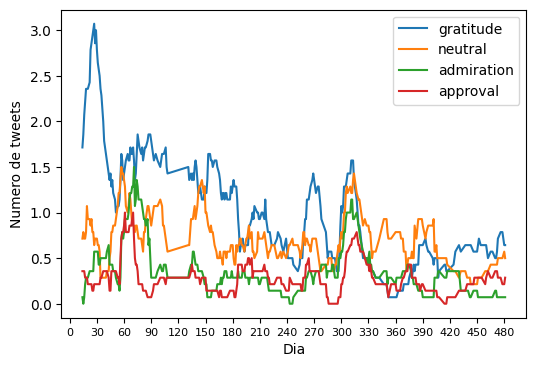

In [29]:
k = 4
top_k_emotions = emotions_over_time[emotions_over_time.sum().sort_values(ascending=False).index[:k]]
rolling_mean_emotions = top_k_emotions.rolling(window=14, axis = 0).mean()

fig, ax = plt.subplots(figsize=(6, 4))

for column in rolling_mean_emotions.columns:
    ax.plot(rolling_mean_emotions[column], label=column)

ax.set_xlabel('Dia')
ax.set_ylabel('Numero de tweets')
ax.set_xticks(np.arange(0, max(data['day_index'])+1, 30))
ax.set_xticklabels(np.arange(0, max(data['day_index'])+1, 30), fontsize=8)

ax.legend()
plt.show()